In [1]:
import pandas as pd
import yaml
import torch
from pytorch_lightning import Trainer, seed_everything
from eyemind.trainer.loops import KFoldLoop
from eyemind.models.classifier import EncoderClassifierMultiSequenceModel, oldEncoderClassifierModel
from eyemind.models.encoder_decoder import VariableSequenceLengthEncoderDecoderModel
from eyemind.dataloading.gaze_data import SequenceToLabelDataModule, SequenceToSequenceDataModule

/opt/homebrew/Caskroom/miniforge/base/envs/eyemind_arm/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
config_path = "./experiment_configs/local/comprehension_nestedcv_test_config.yml"
with open(config_path, "r") as f:
    config = yaml.safe_load(f)

In [3]:
seed_everything(config["seed_everything"], workers=True)

Global seed set to 42


42

## Load Model checkpoint

In [4]:
ckpt_path = "./ray_results/comprehension-tune-sub/fold3_freeze_encoder=False/checkpoints/epoch=19-step=460.ckpt"    
model = oldEncoderClassifierModel.load_from_checkpoint(ckpt_path,encoder_weights_path=None)

CNN Layers: [16, 32]
16 2
32 16


/Users/rickgentry/miniforge3/envs/eyemind/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


## Setup Data and Trainer

In [5]:
datamodule = SequenceToLabelDataModule(**config["data"])
datamodule.setup()

In [6]:
datamodule.setup_cv_folds(4,4)

In [7]:
datamodule.setup_cv_fold_index(3,-1)

In [8]:
trainer = Trainer(**config["trainer"])

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


## Predictions

In [9]:
train_dl = datamodule.get_dataloader(datamodule.train_fold)
val_dl = datamodule.get_dataloader(datamodule.val_fold)
test_dl = datamodule.test_dataloader()

In [12]:
train_preds = trainer.predict(model, train_dl)
val_preds = trainer.predict(model, val_dl)
test_preds = trainer.predict(model, test_dl)

/Users/rickgentry/miniforge3/envs/eyemind/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting DataLoader 0: 100%|██████████| 12/12 [00:11<00:00,  1.06it/s]


In [16]:
def get_fraction_of_comprehension(preds):
    return torch.cat(preds).mean()

In [19]:
print(f"train:{get_fraction_of_comprehension(train_preds)}, val: {get_fraction_of_comprehension(val_preds)}, test: {get_fraction_of_comprehension(test_preds)}")

train:0.6068152189254761, val: 0.580152690410614, test: 0.591160237789154


## Predictive Coding

In [3]:
%load_ext autoreload
%autoreload 2

In [2]:
from eyemind.obf.utils.signal_visualization import *
from eyemind.analysis.predictions import *
from eyemind.models.encoder_decoder import *



### MultiTaskEncoderDecoder

In [3]:
checkpoint_path = "./lightning_logs/multitask_encdec_seq500_dim256_epochs100/checkpoints/epoch=99-step=1600.ckpt"

In [4]:
model = load_model_from_checkpoint(MultiTaskEncoderDecoder, checkpoint_path)

CNN Layers: [16, 32]
16 2
32 16
CNN Layers: [16, 32]
16 2
32 16


/opt/homebrew/Caskroom/miniforge/base/envs/eyemind_arm/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [5]:
dl = get_dataloader("./lightning_logs/multitask_encdec_seq500_dim256_epochs100/config.yaml")

In [6]:
for batch in dl:
    preds = model.predict_step(batch, 0)
    break


In [7]:
pc_preds = preds["pc"][:4]
rc_preds = preds["rc"][:4]


In [8]:
pc_targets = batch[0][:4,-100:]
rc_targets = batch[0][:4,:-100]

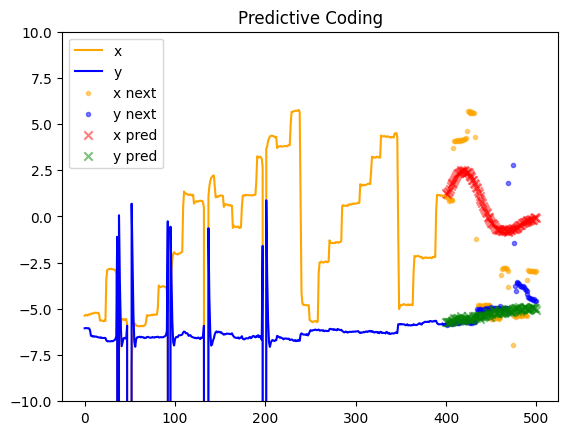

In [14]:
from eyemind.obf.utils.signal_visualization import *
viz_pred_code(rc_targets, pc_targets, pc_preds, "Predictive Coding")

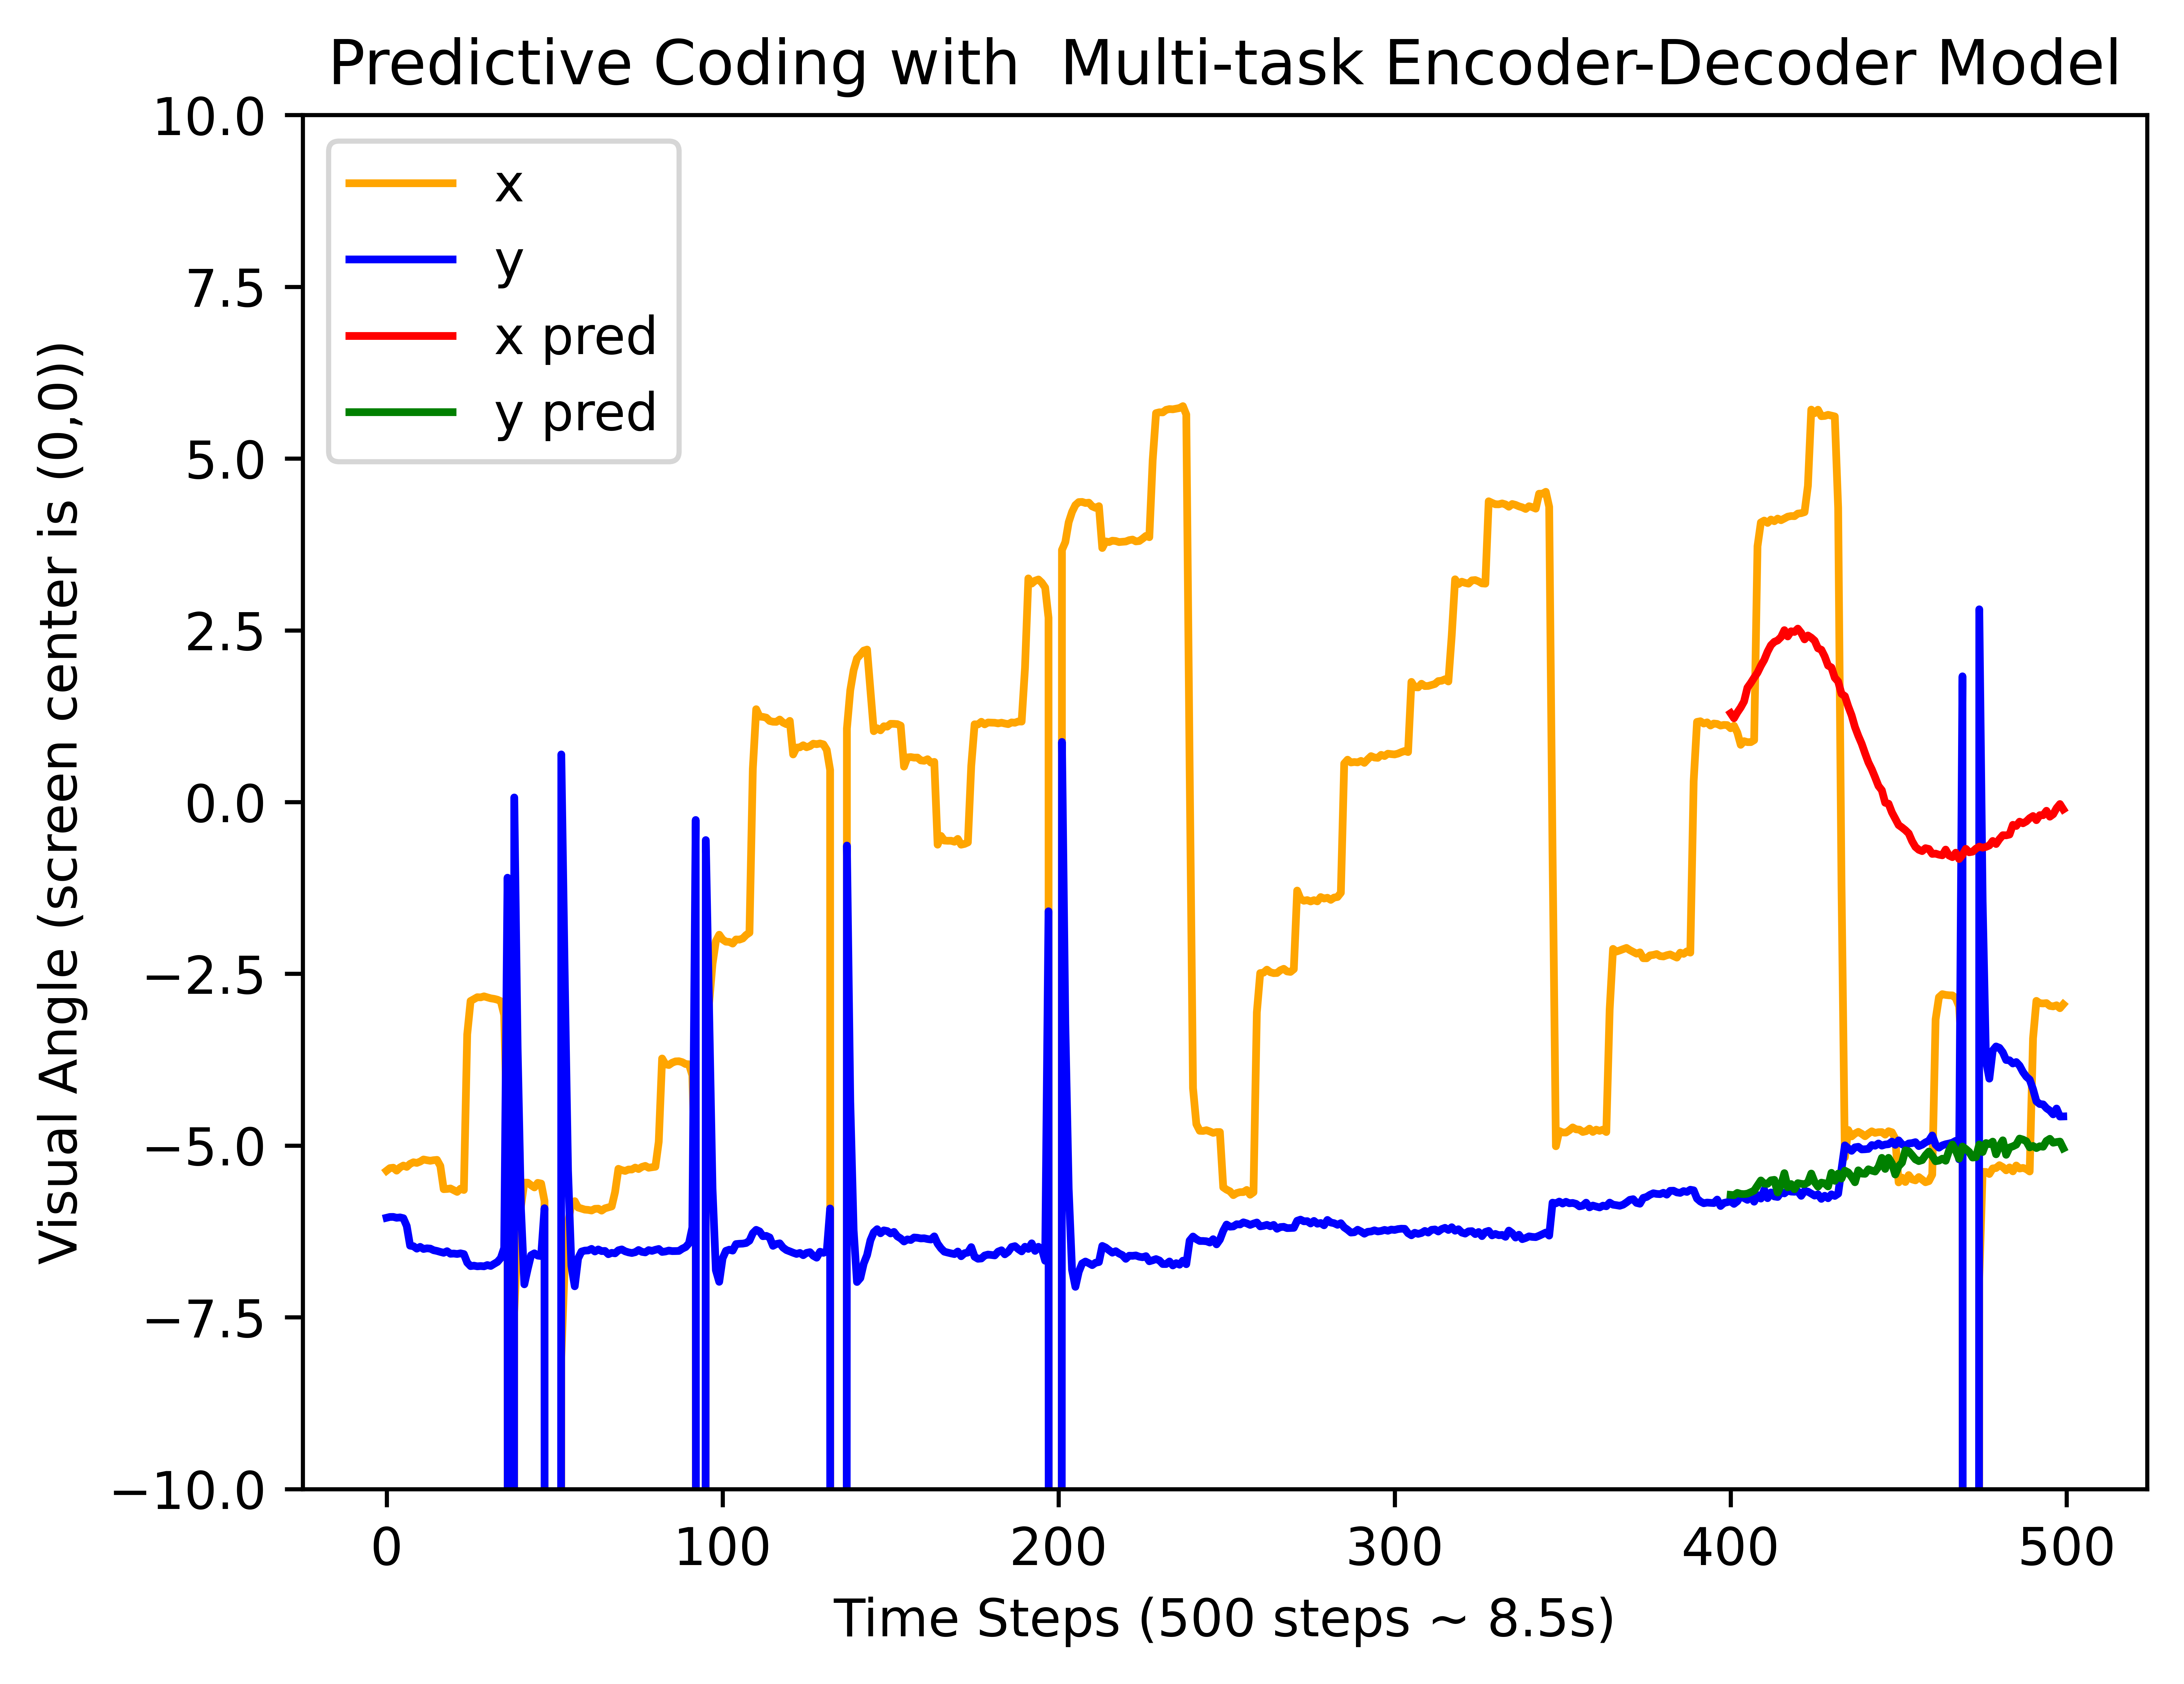

In [24]:
from eyemind.analysis.visualize import viz_coding
viz_coding(batch[0][:4], pc_preds, "Predictive Coding with  Multi-task Encoder-Decoder Model")

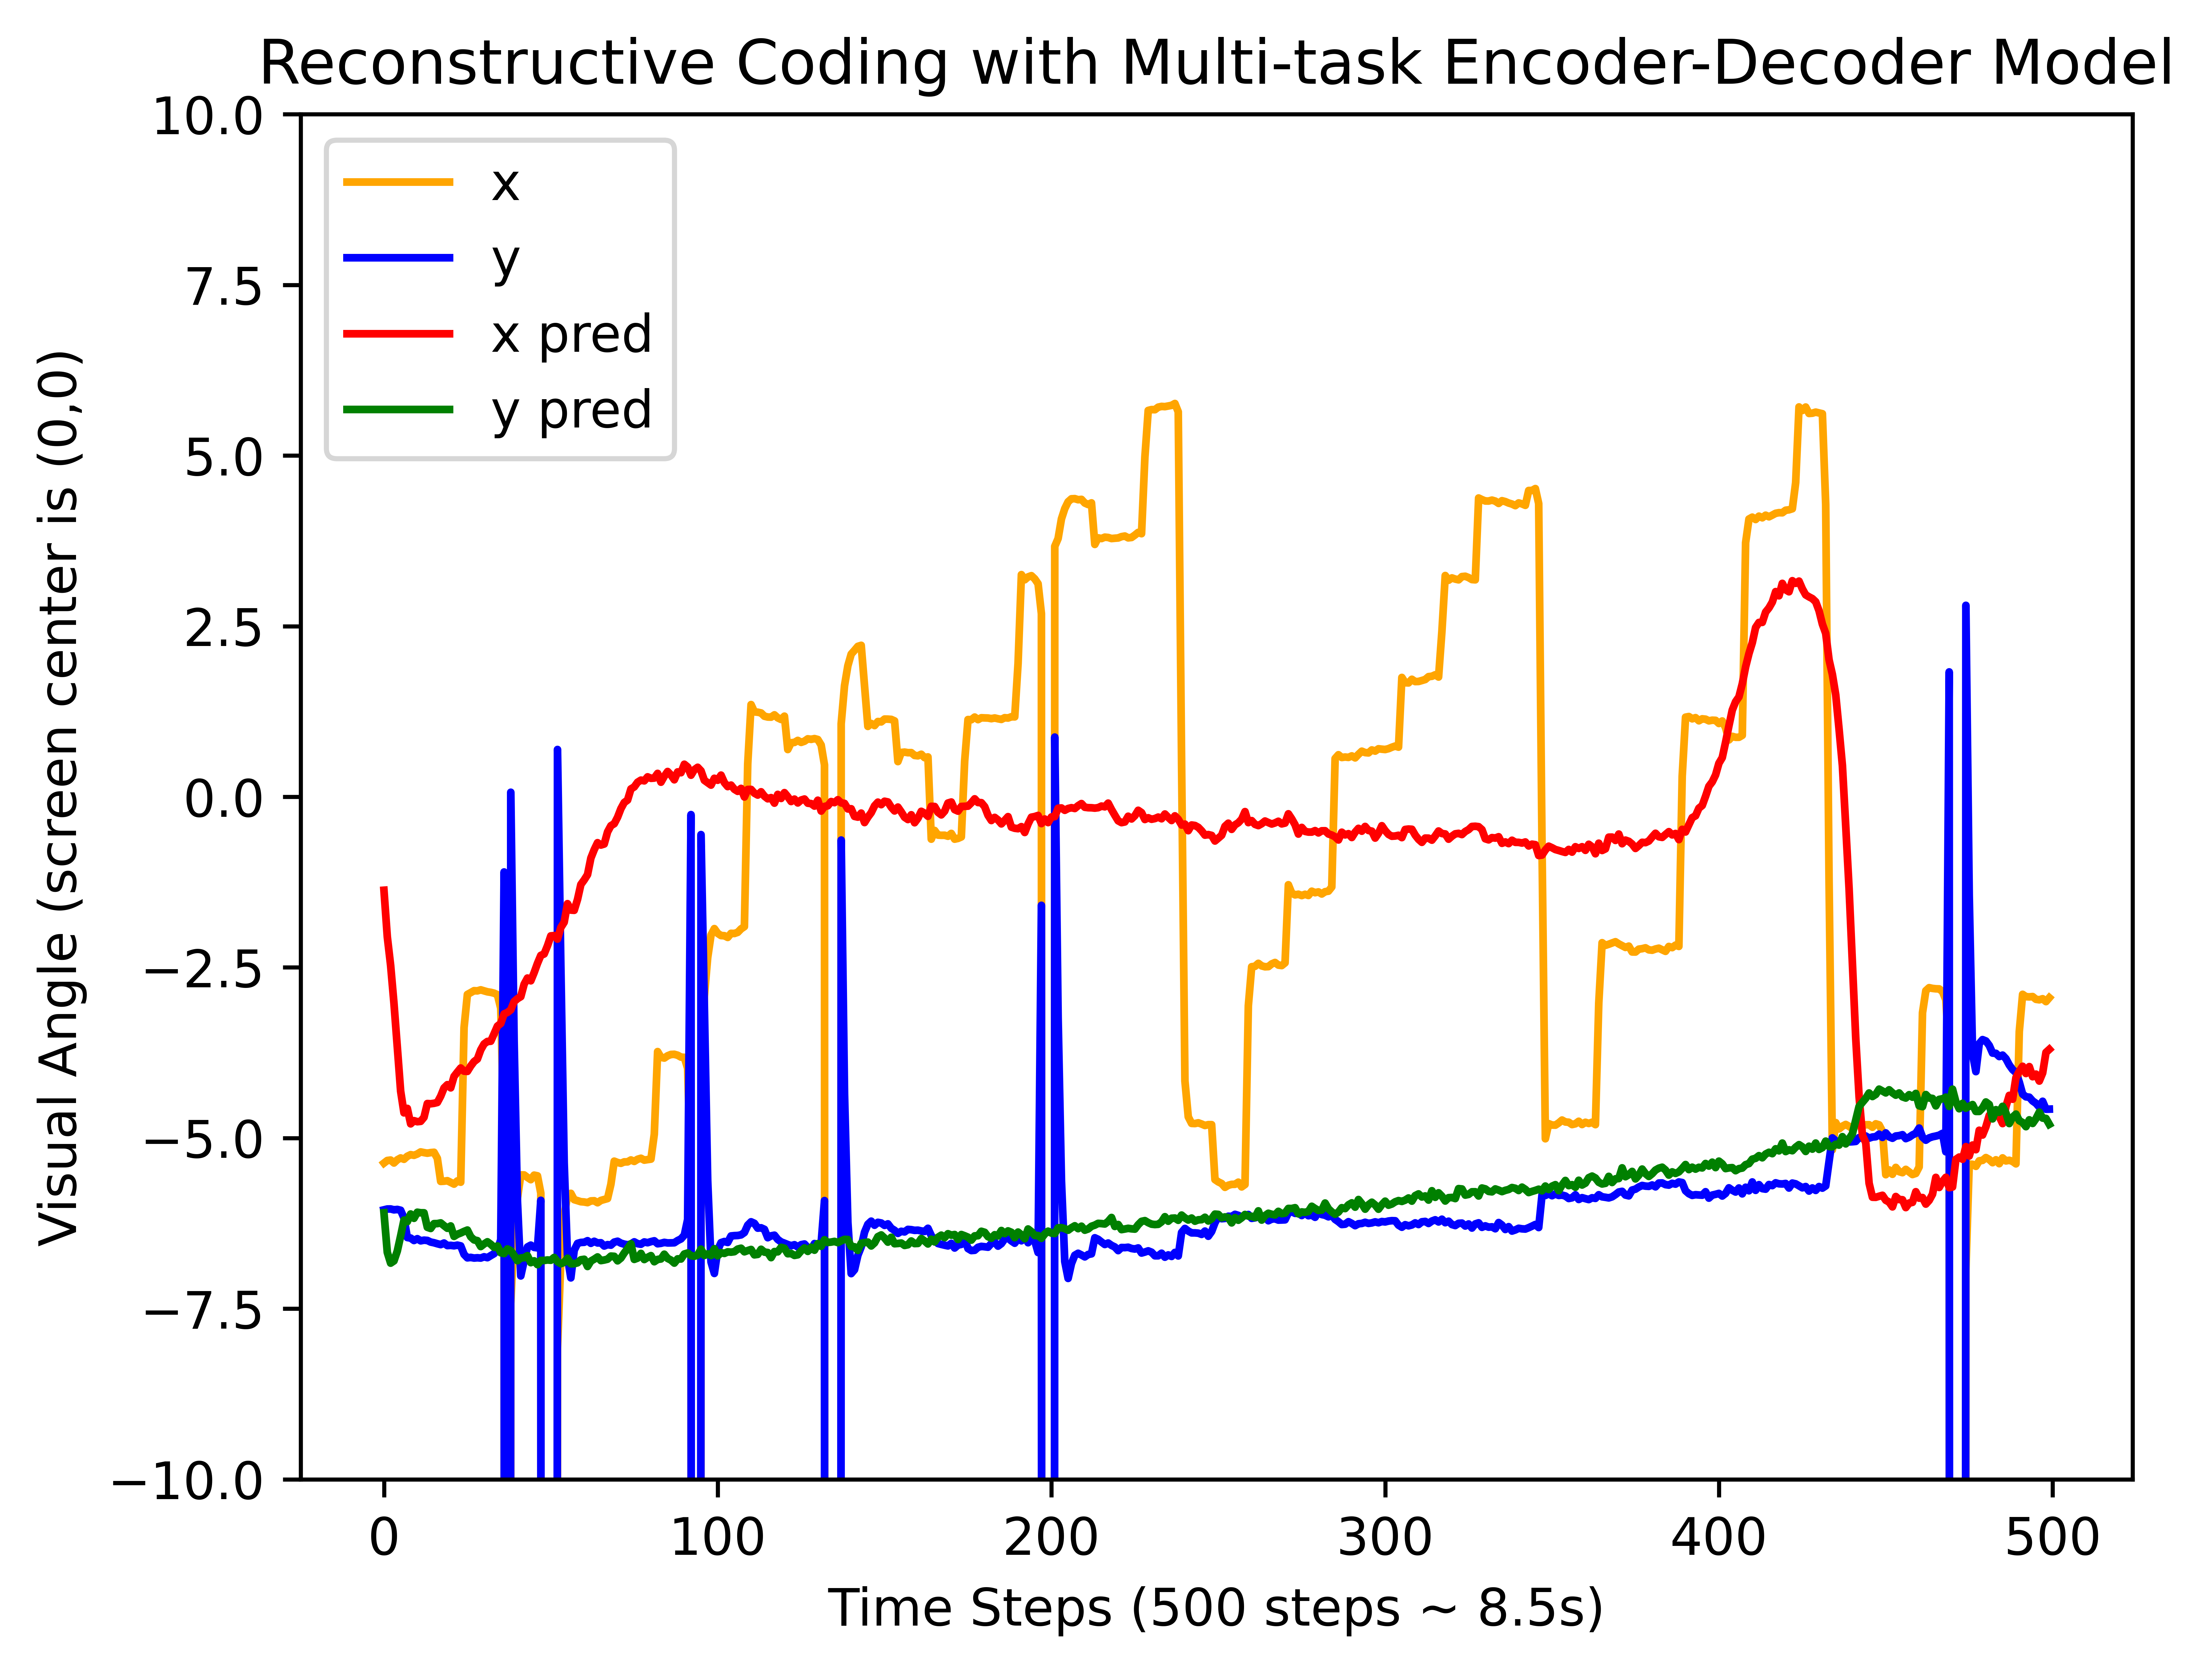

In [22]:
viz_coding(batch[0][:4], rc_preds, "Reconstructive Coding with Multi-task Encoder-Decoder Model")

### Predictive Coding Transformer

In [1]:
from eyemind.models.transformers import InformerEncoderDecoderModel, InformerEncoderFixationModel, InformerClassifierModel
from eyemind.dataloading.informer_data import InformerDataModule
from eyemind.dataloading.gaze_data import SequenceToLabelDataModule
from eyemind.dataloading.batch_loading import predictive_coding_batch

/opt/homebrew/Caskroom/miniforge/base/envs/eyemind_arm/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
checkpoint_path = "./lightning_logs/informer_fix_pc_500seq_120epochs/checkpoints/epoch=120-step=2057.ckpt"
model = load_model_from_checkpoint(InformerEncoderFixationModel, checkpoint_path)
dl = get_dataloader("./lightning_logs/informer_pc_500seq_100epochs/config.yaml", dm_cls=InformerDataModule)

In [7]:
classifier = InformerClassifierModel(encoder_ckpt="./lightning_logs/informer_fix_pc_500seq_120epochs/checkpoints/epoch=120-step=2057.ckpt", freeze_encoder=True)

/opt/homebrew/Caskroom/miniforge/base/envs/eyemind_arm/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [3]:
data_dir = "./data/processed/output"
label_filepath = "./data/processed/EML1_pageLevel_500+_matchEDMinstances.csv"
label_col = "Rote_X"
sequence_length = 500
dm = SequenceToLabelDataModule(data_dir, label_filepath,label_col,sequence_length=sequence_length, scale=True, num_workers=1 )
dm.setup("fit")

In [4]:
dl = dm.train_dataloader()

In [8]:
for batch in dl:
    classifier(batch[0])
    break

In [7]:
from eyemind.dataloading.transforms import StandardScaler
scaler = StandardScaler()

In [8]:

for batch in dl:
    X_pc, Y_pc = predictive_coding_batch(batch[0], model.hparams.seq_len, model.hparams.pred_len, model.hparams.label_len)
    preds = model(X_pc, Y_pc).squeeze()
    preds = scaler.inverse_transform(preds)
    Y_pc = scaler.inverse_transform(Y_pc)
    break


In [9]:
X_pc.shape, preds.shape, Y_pc.shape

(torch.Size([64, 500, 2]), torch.Size([64, 500, 2]), torch.Size([64, 100, 2]))

In [10]:
X_pc = scaler.inverse_transform(X_pc)

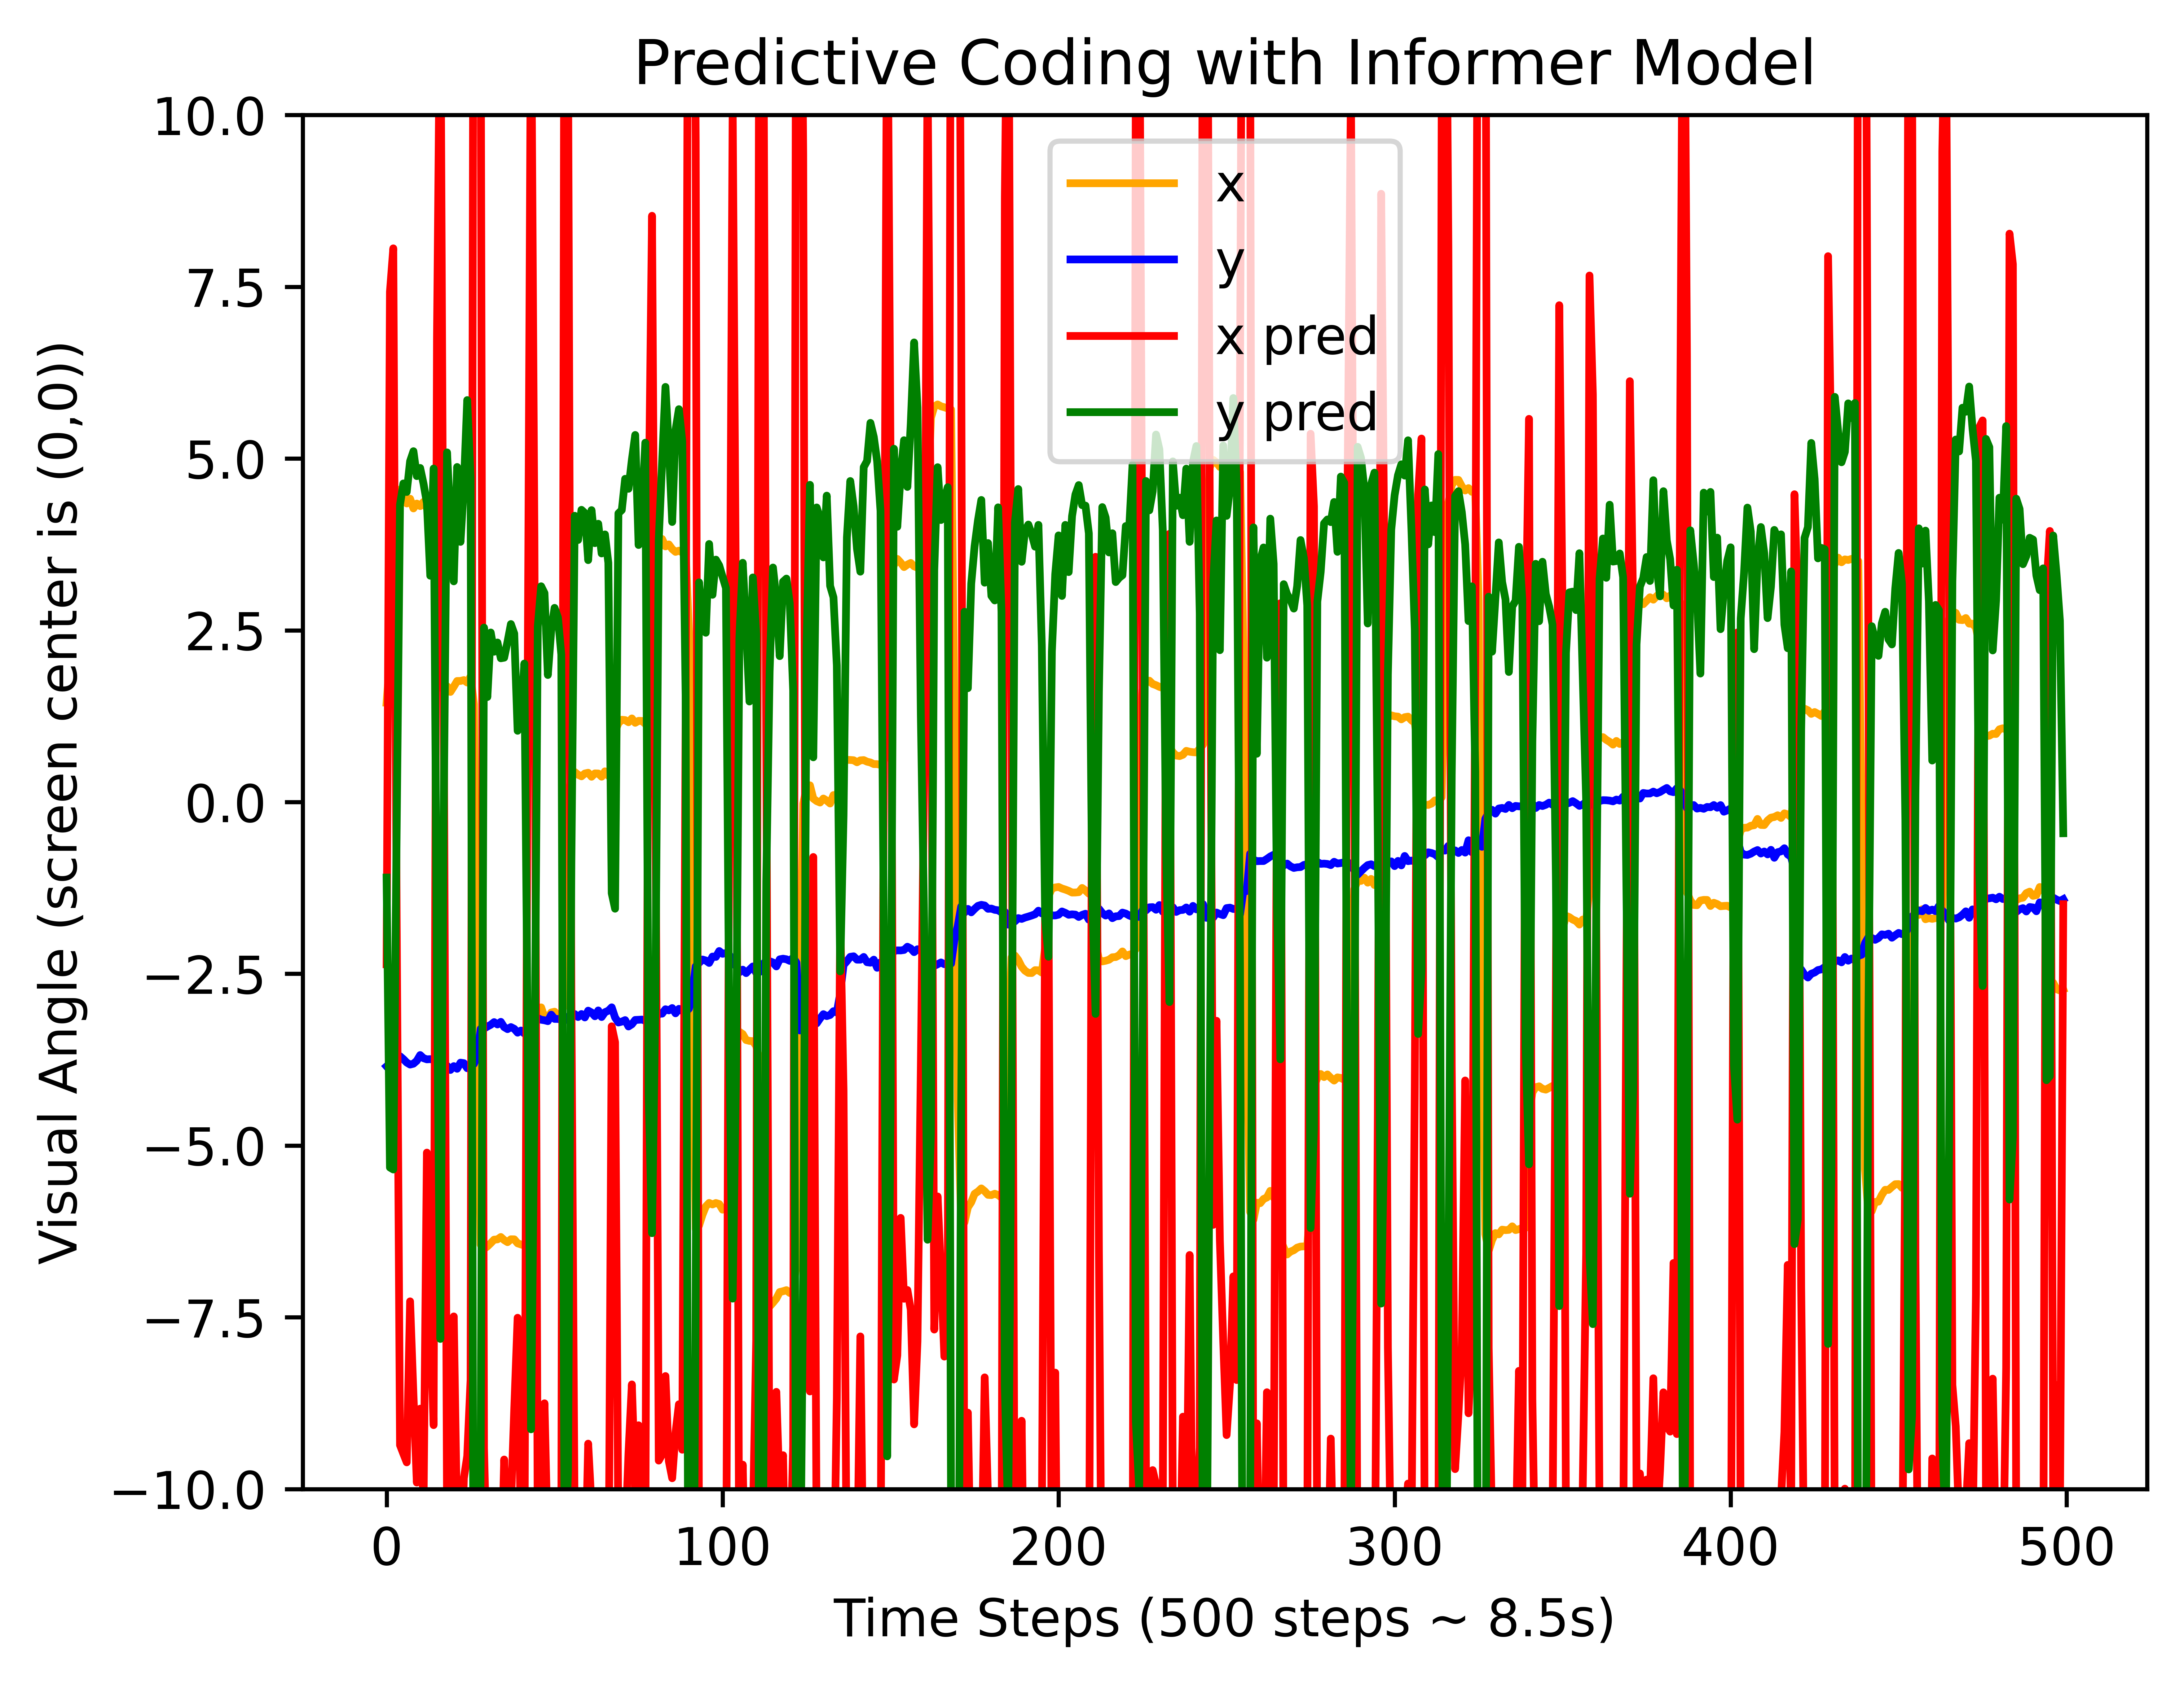

In [11]:
from eyemind.analysis.visualize import viz_coding
viz_coding(X_pc[:4], preds[:4], "Predictive Coding with Informer Model")